In [1]:
# limit the thread used by numpy for better parallelization
import os

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
# import logging

# sys.path.append("..")
from Triangle.Constants import *
from Triangle.FFTTools import *
from Triangle.Noise import *
from Triangle.Orbit import *
from Triangle.Data import *
from Triangle.Interferometer import *
from Triangle.TDI import *
from Triangle.Glitch import *
from Triangle.GW import *

try:
    import cupy as xp
    # print("Has Cupy")
    # HAS_GPU = True
except ImportError:
    import numpy as xp
    # print("No Cupy")
    # HAS_GPU = False

# import healpy as hlp

# Uncomment this if LaTeX is installed for better visualization
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

# logging.basicConfig()
# logging.getLogger().setLevel(logging.INFO)

# import multiprocessing

# if __name__ == "__main__":
#     multiprocessing.set_start_method("fork")
# print("number of cpus =", multiprocessing.cpu_count())
# pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
# pool = None

no cupy 


PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


## General implementation 

In [3]:
# set the TCB times of resulting TDI responses
Tobs = 15 * DAY
dt = 5.
tcb_times = np.arange(int(Tobs / dt)) * dt

# orbit model
orbit = Orbit(OrbitDir="../OrbitData/MicroSateOrbitEclipticTCB")

In [4]:
# approximant = "IMRPhenomXPHM"
approximant = "SEOBNRv4_opt"

mbhb_waveform_generator = MBHB_Injection(approx_method=approximant, buffer=True)

mbhb_response_generator = GeneralTDIResponse(
    orbit=orbit,
    Pstring=GeneralTDIResponse.X2_strings,
    tcb_times=tcb_times.copy(),
    use_gpu=False,
    drop_points=int(1000 / dt),
    linear_interp=False,
    return_eta=False, 
)

In [5]:
MBHB_params = {
    "chirp_mass": 100000.0,
    "mass_ratio": 0.3640815267051051,
    "spin_1z": 0.7899406190510447,
    "spin_2z": 0.015424596359292053,
    "coalescence_time": 12.0,
    "coalescence_phase": 3.2535342675592966,
    "luminosity_distance": 106039.10941463517,
    "inclination": 1.4495086550199021,
    "longitude": 3.032776598141215,
    "latitude": -1.1817968279048852,
    "psi": 0.2409146690555858,
}

In [6]:
for _ in tqdm(range(10)):
    X2_general = mbhb_response_generator(parameters=MBHB_params, waveform_generator=mbhb_waveform_generator)
X2_general.shape 

100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


(259200,)

(11.98, 12.01)

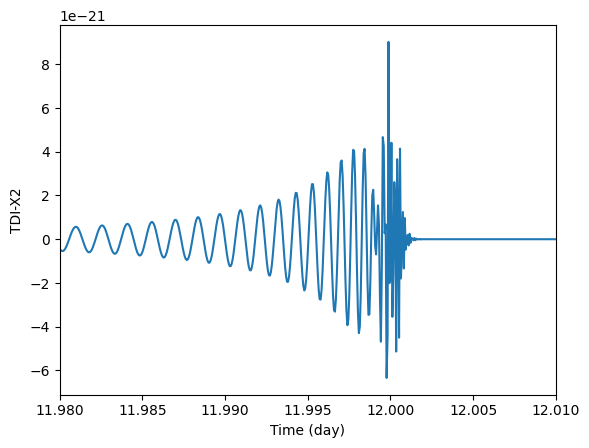

In [7]:
plt.plot(tcb_times / DAY, X2_general)
plt.xlabel("Time (day)")
plt.ylabel("TDI-X2")
# plt.ylim(-1e-23, 1e-23)
plt.xlim(MBHB_params["coalescence_time"] - 0.02, MBHB_params["coalescence_time"] + 0.01)

## Faster implementation 

In [8]:
# import numpy as np
# import scipy.interpolate as interp 
# try:
#     import cupy as xp
#     import cupyx.scipy.interpolate as xinterp
#     print("has cupy")
# except (ImportError, ModuleNotFoundError) as e:
#     import numpy as xp
#     import scipy.interpolate as xinterp  
#     print("no cupy ")

In [9]:

# class FastMichelsonTDIResponse:
#     GB_param_names = ["A", "f0", "fdot0", "phase0", "inclination", "longitude", "latitude", "psi"]
#     MBHB_param_names = ["chirp_mass", "mass_ratio", "spin_1z", "spin_2z", "coalescence_time", "coalescence_phase", "luminosity_distance", "inclination", "longitude", "latitude", "psi"]
#     MBHB_v5_param_names = ["chirp_mass", "mass_ratio", "spin_1z", "spin_2z", "coalescence_time", "reference_phase", "luminosity_distance", "inclination", "longitude", "latitude", "psi", "eccentricity"]
#     general_param_names = ["longitude", "latitude", "psi"]

#     def __init__(self, orbit, tcb_times, use_gpu=False, drop_points=0, interp_method="linear"):
#         """
#         Initialize orbit-specified time delays, which will be used to calculate single-link responses and TDIs 
#         Args:
#             orbit: an orbit object
#             tcb_times: TCB times at which the TDI responses will be calculated, numpy or cupy arraies 
#             use_gpu: if True, the waveform generator should takes cupy arraies as inputs and outputs cupy arraies
#             interp_method shoude be chosen from "linear", "Akima", "Spline3", "Spline4", "Spline5"
#         """
#         self.orbit_object = orbit
#         self.Ntime = len(tcb_times)
#         self.use_gpu = use_gpu
#         self.drop_points = drop_points
        
#         if use_gpu: 
#             self.xp = xp 
#             self.xinterp = xinterp
#         else: 
#             self.xp = np 
#             self.xinterp = interp
#         self.SIN = self.xp.sin
#         self.COS = self.xp.cos 
#         self.MATMUL = self.xp.matmul
#         self.REAL = self.xp.real
#         self.IMAG = self.xp.imag
        
#         if interp_method == "linear": 
#             self.linear_interp = True 
#             self.LIN_INTERP = self.xp.interp
#         else: 
#             self.linear_interp = False 
#             if interp_method == "Akima": 
#                 self.spline_interp = False 
#                 self.interp_class = self.xinterp.Akima1DInterpolator
#                 self.interp_kwargs = dict()
#             elif interp_method == "Spline3": 
#                 self.spline_interp = True 
#                 self.interp_class = self.xinterp.make_interp_spline
#                 self.interp_k_order = 3 
#                 self.interp_kwargs = dict(k=self.interp_k_order)
#             elif interp_method == "Spline4": 
#                 self.spline_interp = True
#                 self.interp_class = self.xinterp.make_interp_spline
#                 self.interp_k_order = 4 
#                 self.interp_kwargs = dict(k=self.interp_k_order)
#             elif interp_method == "Spline5": 
#                 self.spline_interp = True
#                 self.interp_class = self.xinterp.make_interp_spline
#                 self.interp_k_order = 5 
#                 self.interp_kwargs = dict(k=self.interp_k_order)
#             else: 
#                 raise NotImplementedError("Interpolation method not implemented.")
            
#         # the orbit functions use numpy array as input
#         if isinstance(tcb_times, xp.ndarray) and HAS_GPU:
#             self.tcb_times = tcb_times.get() # now self.tcb_times is a numpy array 
#         else: 
#             self.tcb_times = tcb_times.copy() # now self.tcb_times is a numpy array 
            
#         # calculate TDI delays 
#         # 1-link delays 
#         self.d12 = self.xp.array(orbit.LTTfunctions()["12"](self.tcb_times)) # (Nt,)
#         self.d23 = self.xp.array(orbit.LTTfunctions()["23"](self.tcb_times))
#         self.d31 = self.xp.array(orbit.LTTfunctions()["31"](self.tcb_times))
#         self.d21 = self.xp.array(orbit.LTTfunctions()["21"](self.tcb_times))
#         self.d32 = self.xp.array(orbit.LTTfunctions()["32"](self.tcb_times))
#         self.d13 = self.xp.array(orbit.LTTfunctions()["13"](self.tcb_times))
#         # 2-link delays 
#         self.d212 = self.d21 + self.d12 # (Nt,) some of the variables are duplicated, but it won't affect the speed of response calculation 
#         self.d232 = self.d23 + self.d32 
#         self.d323 = self.d32 + self.d23 
#         self.d313 = self.d31 + self.d13 
#         self.d131 = self.d13 + self.d31 
#         self.d121 = self.d12 + self.d21 
#         # 4-link delays 
#         self.d23212 = self.d232 + self.d212 # (Nt,)
#         self.d31323 = self.d313 + self.d323 
#         self.d12131 = self.d121 + self.d131 

#         # calculate orbit variables 
#         # arm vectors 
#         self.arm_vector_dict = assign_function_for_MOSAs(
#             functions=orbit.ArmVectorfunctions(),
#             proper_time=self.tcb_times,
#         )  
#         for key in MOSA_labels:
#             self.arm_vector_dict[key] = self.xp.array(self.arm_vector_dict[key]) # each item is a xp array of shape (Ntime, 3)
#         # position vectors 
#         self.position_vector_dict = assign_function_for_SCs(
#             functions=orbit.Positionfunctions(), 
#             proper_time=self.tcb_times, 
#         )
#         for key in SC_labels: 
#             self.position_vector_dict[key] = self.xp.array(self.position_vector_dict[key]) # each item is a xp array of shape (Ntime, 3)

#         self.tcb_times = self.xp.array(self.tcb_times) 
#         self.ep_0 = self.xp.array([[1, 0, 0], [0, -1, 0], [0, 0, 0]])
#         self.ec_0 = self.xp.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]])

#     def __call__(self, parameters, waveform_generator, optimal_combination=False):
#         """
#         Args:
#             parameters: a dictionary storing the source parameters
#             waveform_generator: a waveform object, which has a __call__ function that returns source-frame polarizations hp + ihc for given parameters
#         Returns:
#             the time series of TDI responses XYZ (optimal_combination=False) or AET (optimal_combination=True), shape is (3, Nt)
#         """
#         self.waveform_generator = waveform_generator

#         # calculate wave vector and polar bases using the extrinsic parameters
#         l = parameters["longitude"]
#         b = parameters["latitude"]
#         p = parameters["psi"]

#         wave_vector = -self.xp.array([self.COS(l) * self.COS(b), self.SIN(l) * self.COS(b), self.SIN(b)])  # (3)

#         O = self.xp.zeros((3, 3))
#         O[0][0] = self.SIN(l) * self.COS(p) - self.COS(l) * self.SIN(b) * self.SIN(p)
#         O[0][1] = -self.SIN(l) * self.SIN(p) - self.COS(l) * self.SIN(b) * self.COS(p)
#         O[0][2] = -self.COS(l) * self.COS(b)
#         O[1][0] = -self.COS(l) * self.COS(p) - self.SIN(l) * self.SIN(b) * self.SIN(p)
#         O[1][1] = self.COS(l) * self.SIN(p) - self.SIN(l) * self.SIN(b) * self.COS(p)
#         O[1][2] = -self.SIN(l) * self.COS(b)
#         O[2][0] = self.COS(b) * self.SIN(p)
#         O[2][1] = self.COS(b) * self.COS(p)
#         O[2][2] = -self.SIN(b)
#         OT = O.transpose()
#         e_p = self.xp.dot(self.xp.dot(O, self.ep_0), OT)  # (3, 3)
#         e_c = self.xp.dot(self.xp.dot(O, self.ec_0), OT)  # (3, 3)

#         # calculate fiducial waveforms at tcb_times, and the delayed ones will be obtained via interpolation
#         times_interp, hphc0 = self.waveform_generator(parameters, self.tcb_times)  # times_interp does not has to be the same as tcb_times, it only acts as the x value of interpolation

#         # calculate pattern function 
#         Fp12 = self.xp.sum(self.MATMUL(self.arm_vector_dict["12"], e_p) * self.arm_vector_dict["12"], axis=1)  # Fp12=Fp21 (Ntime)
#         Fp23 = self.xp.sum(self.MATMUL(self.arm_vector_dict["23"], e_p) * self.arm_vector_dict["23"], axis=1)
#         Fp31 = self.xp.sum(self.MATMUL(self.arm_vector_dict["31"], e_p) * self.arm_vector_dict["31"], axis=1)
#         Fc12 = self.xp.sum(self.MATMUL(self.arm_vector_dict["12"], e_c) * self.arm_vector_dict["12"], axis=1)  # Fc12=Fc21 (Ntime)
#         Fc23 = self.xp.sum(self.MATMUL(self.arm_vector_dict["23"], e_c) * self.arm_vector_dict["23"], axis=1)
#         Fc31 = self.xp.sum(self.MATMUL(self.arm_vector_dict["31"], e_c) * self.arm_vector_dict["31"], axis=1)
        
#         Denominator12 = (self.MATMUL(self.arm_vector_dict["12"], wave_vector) - 1.0) * (-2.0)  # (Ntime)
#         Denominator23 = (self.MATMUL(self.arm_vector_dict["23"], wave_vector) - 1.0) * (-2.0) 
#         Denominator31 = (self.MATMUL(self.arm_vector_dict["31"], wave_vector) - 1.0) * (-2.0)  
#         Denominator21 = (self.MATMUL(self.arm_vector_dict["21"], wave_vector) - 1.0) * (-2.0)  
#         Denominator32 = (self.MATMUL(self.arm_vector_dict["32"], wave_vector) - 1.0) * (-2.0) 
#         Denominator13 = (self.MATMUL(self.arm_vector_dict["13"], wave_vector) - 1.0) * (-2.0)  
        
#         kR1overC = self.MATMUL(self.position_vector_dict["1"], wave_vector) / C # (Ntime)
#         kR2overC = self.MATMUL(self.position_vector_dict["2"], wave_vector) / C 
#         kR3overC = self.MATMUL(self.position_vector_dict["3"], wave_vector) / C 
            
#         if self.linear_interp:      
#             dh12 = self.LIN_INTERP(x=self.tcb_times - self.d12 - kR2overC, xp=times_interp, fp=hphc0, left=0., right=0.) - self.LIN_INTERP(x=self.tcb_times - kR1overC, xp=times_interp, fp=hphc0, left=0., right=0.) # (Ntime), complex 
#             dh23 = self.LIN_INTERP(x=self.tcb_times - self.d23 - kR3overC, xp=times_interp, fp=hphc0, left=0., right=0.) - self.LIN_INTERP(x=self.tcb_times - kR2overC, xp=times_interp, fp=hphc0, left=0., right=0.)
#             dh31 = self.LIN_INTERP(x=self.tcb_times - self.d31 - kR1overC, xp=times_interp, fp=hphc0, left=0., right=0.) - self.LIN_INTERP(x=self.tcb_times - kR3overC, xp=times_interp, fp=hphc0, left=0., right=0.)
#             dh21 = self.LIN_INTERP(x=self.tcb_times - self.d21 - kR1overC, xp=times_interp, fp=hphc0, left=0., right=0.) - self.LIN_INTERP(x=self.tcb_times - kR2overC, xp=times_interp, fp=hphc0, left=0., right=0.)
#             dh32 = self.LIN_INTERP(x=self.tcb_times - self.d32 - kR2overC, xp=times_interp, fp=hphc0, left=0., right=0.) - self.LIN_INTERP(x=self.tcb_times - kR3overC, xp=times_interp, fp=hphc0, left=0., right=0.)
#             dh13 = self.LIN_INTERP(x=self.tcb_times - self.d13 - kR3overC, xp=times_interp, fp=hphc0, left=0., right=0.) - self.LIN_INTERP(x=self.tcb_times - kR1overC, xp=times_interp, fp=hphc0, left=0., right=0.)
            
#             eta12 = (Fp12 * self.REAL(dh12) + Fc12 * self.IMAG(dh12)) / Denominator12 # (Ntime)
#             eta23 = (Fp23 * self.REAL(dh23) + Fc23 * self.IMAG(dh23)) / Denominator23
#             eta31 = (Fp31 * self.REAL(dh31) + Fc31 * self.IMAG(dh31)) / Denominator31
#             eta21 = (Fp12 * self.REAL(dh21) + Fc12 * self.IMAG(dh21)) / Denominator21
#             eta32 = (Fp23 * self.REAL(dh32) + Fc23 * self.IMAG(dh32)) / Denominator32
#             eta13 = (Fp31 * self.REAL(dh13) + Fc31 * self.IMAG(dh13)) / Denominator13
            
#             X0plus = eta12 + self.LIN_INTERP(x=self.tcb_times - self.d12, xp=self.tcb_times, fp=eta21, left=0., right=0.)
#             X0minus = eta13 + self.LIN_INTERP(x=self.tcb_times - self.d13, xp=self.tcb_times, fp=eta31, left=0., right=0.)
#             X1plus = X0plus - self.LIN_INTERP(x=self.tcb_times - self.d131, xp=self.tcb_times, fp=X0plus, left=0., right=0.)
#             X1minus = X0minus - self.LIN_INTERP(x=self.tcb_times - self.d121, xp=self.tcb_times, fp=X0minus, left=0., right=0.) 
#             X2_tmp = X1plus - X1minus
#             X2 = X2_tmp - self.LIN_INTERP(x=self.tcb_times - self.d12131, xp=self.tcb_times, fp=X2_tmp, left=0., right=0.) # (Ntime)
            
#             Y0plus = eta23 + self.LIN_INTERP(x=self.tcb_times - self.d23, xp=self.tcb_times, fp=eta32, left=0., right=0.)
#             Y0minus = eta21 + self.LIN_INTERP(x=self.tcb_times - self.d21, xp=self.tcb_times, fp=eta12, left=0., right=0.)
#             Y1plus = Y0plus - self.LIN_INTERP(x=self.tcb_times - self.d212, xp=self.tcb_times, fp=Y0plus, left=0., right=0.)
#             Y1minus = Y0minus - self.LIN_INTERP(x=self.tcb_times - self.d232, xp=self.tcb_times, fp=Y0minus, left=0., right=0.) 
#             Y2_tmp = Y1plus - Y1minus
#             Y2 = Y2_tmp - self.LIN_INTERP(x=self.tcb_times - self.d23212, xp=self.tcb_times, fp=Y2_tmp, left=0., right=0.) # (Ntime)

#             Z0plus = eta31 + self.LIN_INTERP(x=self.tcb_times - self.d31, xp=self.tcb_times, fp=eta13, left=0., right=0.)
#             Z0minus = eta32 + self.LIN_INTERP(x=self.tcb_times - self.d32, xp=self.tcb_times, fp=eta23, left=0., right=0.)
#             Z1plus = Z0plus - self.LIN_INTERP(x=self.tcb_times - self.d323, xp=self.tcb_times, fp=Z0plus, left=0., right=0.)
#             Z1minus = Z0minus - self.LIN_INTERP(x=self.tcb_times - self.d313, xp=self.tcb_times, fp=Z0minus, left=0., right=0.) 
#             Z2_tmp = Z1plus - Z1minus
#             Z2 = Z2_tmp - self.LIN_INTERP(x=self.tcb_times - self.d31323, xp=self.tcb_times, fp=Z2_tmp, left=0., right=0.) # (Ntime)

#         else:
#             hp_func = self.interp_class(x=times_interp, y=self.REAL(hphc0), **self.interp_kwargs)
#             hc_func = self.interp_class(x=times_interp, y=self.IMAG(hphc0), **self.interp_kwargs)
                
#             t_send = self.tcb_times - self.d12 - kR2overC
#             t_recv = self.tcb_times - kR1overC
#             dhp12 = hp_func(t_send, extrapolate=False) - hp_func(t_recv, extrapolate=False) # (Ntime)
#             dhc12 = hc_func(t_send, extrapolate=False) - hc_func(t_recv, extrapolate=False)
            
#             t_send = self.tcb_times - self.d23 - kR3overC
#             t_recv = self.tcb_times - kR2overC
#             dhp23 = hp_func(t_send, extrapolate=False) - hp_func(t_recv, extrapolate=False) # (Ntime)
#             dhc23 = hc_func(t_send, extrapolate=False) - hc_func(t_recv, extrapolate=False)
            
#             t_send = self.tcb_times - self.d31 - kR1overC
#             t_recv = self.tcb_times - kR3overC
#             dhp31 = hp_func(t_send, extrapolate=False) - hp_func(t_recv, extrapolate=False) # (Ntime)
#             dhc31 = hc_func(t_send, extrapolate=False) - hc_func(t_recv, extrapolate=False)
            
#             t_send = self.tcb_times - self.d21 - kR1overC
#             t_recv = self.tcb_times - kR2overC
#             dhp21 = hp_func(t_send, extrapolate=False) - hp_func(t_recv, extrapolate=False) # (Ntime)
#             dhc21 = hc_func(t_send, extrapolate=False) - hc_func(t_recv, extrapolate=False)
            
#             t_send = self.tcb_times - self.d32 - kR2overC
#             t_recv = self.tcb_times - kR3overC
#             dhp32 = hp_func(t_send, extrapolate=False) - hp_func(t_recv, extrapolate=False) # (Ntime)
#             dhc32 = hc_func(t_send, extrapolate=False) - hc_func(t_recv, extrapolate=False)
            
#             t_send = self.tcb_times - self.d13 - kR3overC
#             t_recv = self.tcb_times - kR1overC
#             dhp13 = hp_func(t_send, extrapolate=False) - hp_func(t_recv, extrapolate=False) # (Ntime)
#             dhc13 = hc_func(t_send, extrapolate=False) - hc_func(t_recv, extrapolate=False)
            
#             eta12 = self.xp.nan_to_num((Fp12 * dhp12 + Fc12 * dhc12) / Denominator12, nan=0.) # (Ntime)
#             eta23 = self.xp.nan_to_num((Fp23 * dhp23 + Fc23 * dhc23) / Denominator23, nan=0.)
#             eta31 = self.xp.nan_to_num((Fp31 * dhp31 + Fc31 * dhc31) / Denominator31, nan=0.)
#             eta21 = self.xp.nan_to_num((Fp12 * dhp21 + Fc12 * dhc21) / Denominator21, nan=0.)
#             eta32 = self.xp.nan_to_num((Fp23 * dhp32 + Fc23 * dhc32) / Denominator32, nan=0.)
#             eta13 = self.xp.nan_to_num((Fp31 * dhp13 + Fc31 * dhc13) / Denominator13, nan=0.)
            
#             eta12_func = self.interp_class(x=self.tcb_times, y=eta12, **self.interp_kwargs)
#             eta23_func = self.interp_class(x=self.tcb_times, y=eta23, **self.interp_kwargs)
#             eta31_func = self.interp_class(x=self.tcb_times, y=eta31, **self.interp_kwargs)
#             eta21_func = self.interp_class(x=self.tcb_times, y=eta21, **self.interp_kwargs)
#             eta32_func = self.interp_class(x=self.tcb_times, y=eta32, **self.interp_kwargs)
#             eta13_func = self.interp_class(x=self.tcb_times, y=eta13, **self.interp_kwargs)
            
#             # X2 = eta12 - eta12_func(self.tcb_times-self.d131, extrapolate=False) - eta12_func(self.tcb_times-self.d12131, extrapolate=False) + eta12_func(self.tcb_times-self.d12131-self.d131, extrapolate=False) \
#             #     - eta31_func(self.tcb_times - self.d13, extrapolate=False) + eta31_func(self.tcb_times - self.d121 - self.d13, extrapolate=False) + eta31_func(self.tcb_times - self.d12131 - self.d13, extrapolate=False) - eta13_func(self.tcb_times - self.d12131 - self.d121 - self.d13, extrapolate=False) \
#             #     + eta21_func(self.tcb_times - self.d12, extrapolate=False) - eta21_func(self.tcb_times - self.d131 - self.d12, extrapolate=False) - eta21_func(self.tcb_times - self.d12131 - self.d12, extrapolate=False) + eta21_func(self.tcb_times - self.d12131 - self.d131 - self.d12, extrapolate=False) \
#             #     - eta13 + eta13_func(self.tcb_times - self.d121, extrapolate=False) + eta13_func(self.tcb_times - self.d12131, extrapolate=False) - eta13_func(self.tcb_times - self.d12131 - self.d121, extrapolate=False)

#             # Y2 = eta23 - eta23_func(self.tcb_times-self.d212, extrapolate=False) - eta23_func(self.tcb_times-self.d23212, extrapolate=False) + eta23_func(self.tcb_times-self.d23212-self.d212, extrapolate=False) \
#             #     - eta12_func(self.tcb_times - self.d21, extrapolate=False) + eta12_func(self.tcb_times - self.d232 - self.d21, extrapolate=False) + eta12_func(self.tcb_times - self.d23212 - self.d21, extrapolate=False) - eta21_func(self.tcb_times - self.d23212 - self.d232 - self.d21, extrapolate=False) \
#             #     + eta32_func(self.tcb_times - self.d23, extrapolate=False) - eta32_func(self.tcb_times - self.d212 - self.d23, extrapolate=False) - eta32_func(self.tcb_times - self.d23212 - self.d23, extrapolate=False) + eta32_func(self.tcb_times - self.d23212 - self.d212 - self.d23, extrapolate=False) \
#             #     - eta21 + eta21_func(self.tcb_times - self.d232, extrapolate=False) + eta21_func(self.tcb_times - self.d23212, extrapolate=False) - eta21_func(self.tcb_times - self.d23212 - self.d232, extrapolate=False)

#             # Z2 = eta31 - eta31_func(self.tcb_times-self.d323, extrapolate=False) - eta31_func(self.tcb_times-self.d31323, extrapolate=False) + eta31_func(self.tcb_times-self.d31323-self.d323, extrapolate=False) \
#             #     - eta23_func(self.tcb_times - self.d32, extrapolate=False) + eta23_func(self.tcb_times - self.d313 - self.d32, extrapolate=False) + eta23_func(self.tcb_times - self.d31323 - self.d32, extrapolate=False) - eta32_func(self.tcb_times - self.d31323 - self.d313 - self.d32, extrapolate=False) \
#             #     + eta13_func(self.tcb_times - self.d31, extrapolate=False) - eta13_func(self.tcb_times - self.d323 - self.d31, extrapolate=False) - eta13_func(self.tcb_times - self.d31323 - self.d31, extrapolate=False) + eta13_func(self.tcb_times - self.d31323 - self.d323 - self.d31, extrapolate=False) \
#             #     - eta32 + eta32_func(self.tcb_times - self.d313, extrapolate=False) + eta32_func(self.tcb_times - self.d31323, extrapolate=False) - eta32_func(self.tcb_times - self.d31323 - self.d313, extrapolate=False)
            
#             X0plus = self.xp.nan_to_num(eta12 + eta21_func(self.tcb_times - self.d12, extrapolate=False), nan=0.)
#             X0minus = self.xp.nan_to_num(eta13 + eta31_func(self.tcb_times - self.d13, extrapolate=False), nan=0.)
#             X0plus_func = self.interp_class(x=self.tcb_times, y=X0plus, **self.interp_kwargs)
#             X0minus_func = self.interp_class(x=self.tcb_times, y=X0minus, **self.interp_kwargs)
#             X1plus = X0plus - X0plus_func(self.tcb_times - self.d131, extrapolate=False)
#             X1minus = X0minus - X0minus_func(self.tcb_times - self.d121, extrapolate=False)
#             X2_tmp = self.xp.nan_to_num(X1plus - X1minus, nan=0.)
#             X2_tmp_func = self.interp_class(x=self.tcb_times, y=X2_tmp, **self.interp_kwargs)
#             X2 = X2_tmp - X2_tmp_func(self.tcb_times - self.d12131, extrapolate=False) # (Ntime)
            
#             Y0plus = self.xp.nan_to_num(eta23 + eta32_func(self.tcb_times - self.d23, extrapolate=False), nan=0.)
#             Y0minus = self.xp.nan_to_num(eta21 + eta12_func(self.tcb_times - self.d21, extrapolate=False), nan=0.)
#             Y0plus_func = self.interp_class(x=self.tcb_times, y=Y0plus, **self.interp_kwargs)
#             Y0minus_func = self.interp_class(x=self.tcb_times, y=Y0minus, **self.interp_kwargs)
#             Y1plus = Y0plus - Y0plus_func(self.tcb_times - self.d212, extrapolate=False)
#             Y1minus = Y0minus - Y0minus_func(self.tcb_times - self.d232, extrapolate=False)
#             Y2_tmp = self.xp.nan_to_num(Y1plus - Y1minus, nan=0.)
#             Y2_tmp_func = self.interp_class(x=self.tcb_times, y=Y2_tmp, **self.interp_kwargs)
#             Y2 = Y2_tmp - Y2_tmp_func(self.tcb_times - self.d23212, extrapolate=False) # (Ntime)
            
#             Z0plus = self.xp.nan_to_num(eta31 + eta13_func(self.tcb_times - self.d31, extrapolate=False), nan=0.)
#             Z0minus = self.xp.nan_to_num(eta32 + eta23_func(self.tcb_times - self.d32, extrapolate=False), nan=0.)
#             Z0plus_func = self.interp_class(x=self.tcb_times, y=Z0plus, **self.interp_kwargs)
#             Z0minus_func = self.interp_class(x=self.tcb_times, y=Z0minus, **self.interp_kwargs)
#             Z1plus = Z0plus - Z0plus_func(self.tcb_times - self.d323, extrapolate=False)
#             Z1minus = Z0minus - Z0minus_func(self.tcb_times - self.d313, extrapolate=False)
#             Z2_tmp = self.xp.nan_to_num(Z1plus - Z1minus, nan=0.)
#             Z2_tmp_func = self.interp_class(x=self.tcb_times, y=Z2_tmp, **self.interp_kwargs)
#             Z2 = Z2_tmp - Z2_tmp_func(self.tcb_times - self.d31323, extrapolate=False) # (Ntime)
                
#         if optimal_combination: 
#             A2, E2, T2 = AETfromXYZ(X2, Y2, Z2)
#             res_arr = self.xp.array([A2, E2, T2])
#         else: 
#             res_arr = self.xp.array([X2, Y2, Z2])
#         res_arr[:, :self.drop_points] *= 0. 
#         res_arr[:, -self.drop_points:] *= 0. 
#         return self.xp.nan_to_num(res_arr, nan=0.)

In [10]:
# xx = np.linspace(0, 10, 1000)
# yy = np.sin(xx)

# xx_eval = np.linspace(-1, 11, 666)

# yyfunc = xinterp.make_interp_spline(x=xx, y=yy, k=5)
# yy_eval = yyfunc(xx_eval, extrapolate=False)

# yyfunc1 = xinterp.Akima1DInterpolator(x=xx, y=yy)
# yy_eval1 = yyfunc1(xx_eval, extrapolate=False)

# plt.plot(xx, yy)
# plt.plot(xx_eval, yy_eval, linestyle="--")
# plt.plot(xx_eval, yy_eval1, linestyle=":")
# plt.plot(xx_eval, yy_eval - yy_eval1)
# plt.ylim(-1e-3, 1e-3)

In [11]:
mbhb_mich_generator = FastMichelsonTDIResponse(
    orbit=orbit, 
    tcb_times=tcb_times, 
    use_gpu=False, 
    drop_points=int(1000./dt), 
    # interp_method="Spline5", 
    # interp_method="Spline3",
    # interp_method="Akima",
    interp_method="linear",
)

In [12]:
mbhb_mich_generator.arm_vector_dict["12"].shape, mbhb_mich_generator.position_vector_dict["1"].shape

((259200, 3), (259200, 3))

In [13]:
mbhb_mich_generator.position_vector_dict["1"]/AU

array([[ 0.17870111,  0.99376216,  0.00979112],
       [ 0.17870013,  0.99376233,  0.00979112],
       [ 0.17869916,  0.99376249,  0.00979112],
       ...,
       [-0.07689889,  1.00477201,  0.00946758],
       [-0.07689988,  1.00477192,  0.00946758],
       [-0.07690086,  1.00477184,  0.00946758]])

In [14]:
for _ in tqdm(range(10)):
    X2_fastmich, _, _ = mbhb_mich_generator(parameters=MBHB_params, waveform_generator=mbhb_waveform_generator, optimal_combination=False)
X2_fastmich.shape 

100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


(259200,)

(-1e-23, 1e-23)

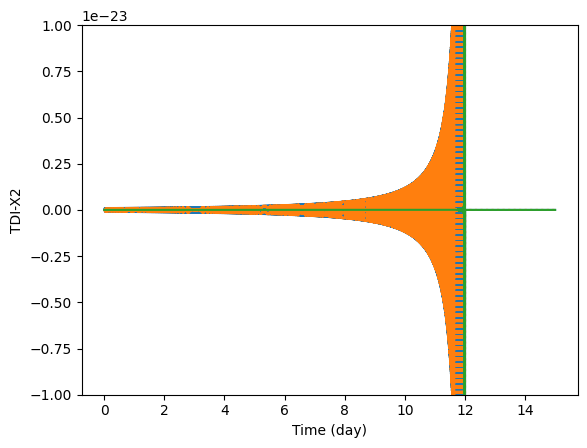

In [15]:
plt.plot(tcb_times / DAY, X2_general)
plt.plot(tcb_times / DAY, X2_fastmich, linestyle=":")
plt.plot(tcb_times / DAY, X2_general - X2_fastmich)
plt.xlabel("Time (day)")
plt.ylabel("TDI-X2")
plt.ylim(-1e-23, 1e-23)
# plt.xlim(MBHB_params["coalescence_time"] - 0.05, MBHB_params["coalescence_time"] + 0.05)
# plt.xlim(0, 1)

(1e-05, 1)

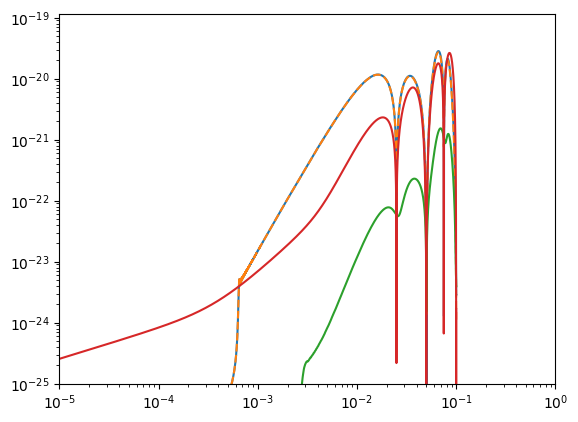

In [16]:
ff, xf = FFT_window(X2_general, 1./dt)
plt.loglog(ff, np.abs(xf) * 2. * ff)

ff, xf1 = FFT_window(X2_fastmich, 1./dt)
plt.loglog(ff, np.abs(xf1) * 2. * ff, linestyle="--")

plt.loglog(ff, np.abs(xf - xf1) * 2. * ff)

PSDfunc = TDIPSDs() 
plt.loglog(ff, np.sqrt(PSDfunc.PSD_X2(ff) * ff))

plt.ylim(1e-25,)
plt.xlim(1e-5, 1)

## Test on GB 

In [17]:
Tobs = YEAR 
dt = 10. 
tcb_times = np.arange(int(Tobs / dt)) * dt 

gb_waveform_generator = GB_Injection(use_gpu=False)

gb_general_response_generator = GeneralTDIResponse(
    orbit=orbit, 
    Pstring=GeneralTDIResponse.X2_strings, 
    tcb_times=tcb_times, 
    use_gpu=False, 
    drop_points=int(1000./dt), 
    linear_interp=False, 
    return_eta=False, 
)

In [18]:
GB_params = {"A": 1.52072235e-22, "f0": 0.00661367, "fdot0": 3.34732748e-17, "phase0": 3.42918555, "inclination": 1.5166699, "longitude": 1.7686, "latitude": 0.10127302, "psi": 0.94753924}
GB_params

{'A': 1.52072235e-22,
 'f0': 0.00661367,
 'fdot0': 3.34732748e-17,
 'phase0': 3.42918555,
 'inclination': 1.5166699,
 'longitude': 1.7686,
 'latitude': 0.10127302,
 'psi': 0.94753924}

In [19]:
for _ in tqdm(range(10)):
    X2_gb_general = gb_general_response_generator(parameters=GB_params, waveform_generator=gb_waveform_generator)
X2_gb_general.shape

100%|██████████| 10/10 [01:31<00:00,  9.12s/it]


(3155814,)

In [20]:
gb_mich_response_generator = FastMichelsonTDIResponse(
    orbit=orbit, 
    tcb_times=tcb_times, 
    use_gpu=False, 
    drop_points=int(1000./dt), 
    interp_method="linear",
)

In [21]:
for _ in tqdm(range(10)):
    X2_gb_mich, _, _ = gb_mich_response_generator(parameters=GB_params, waveform_generator=gb_waveform_generator, optimal_combination=False)
X2_gb_mich.shape

100%|██████████| 10/10 [00:13<00:00,  1.34s/it]


(3155814,)

(0.0, 0.1)

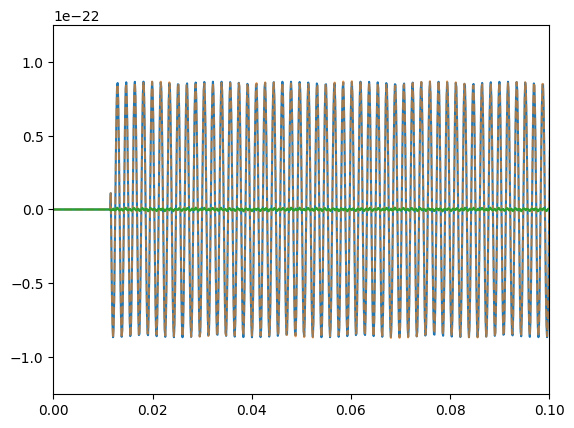

In [22]:
plt.plot(tcb_times/DAY, X2_gb_general)
plt.plot(tcb_times/DAY, X2_gb_mich, linestyle="--", alpha=0.6)
plt.plot(tcb_times/DAY, X2_gb_general - X2_gb_mich)
plt.xlim(0, 0.1)

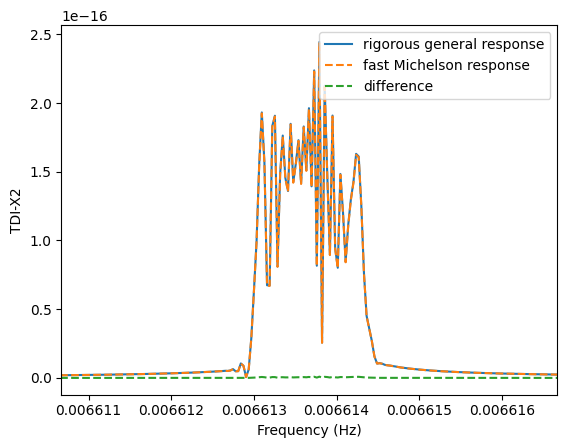

In [24]:
ff, xf = FFT_window(X2_gb_general, 1./dt)
plt.plot(ff, np.abs(xf), label="rigorous general response")

ff, xf1 = FFT_window(X2_gb_mich, 1./dt)
plt.plot(ff, np.abs(xf1), linestyle="--", label="fast Michelson response")

plt.plot(ff, np.abs(xf1 - xf), linestyle="--", label="difference")

plt.xlim(GB_params["f0"] - 0.3e-5, GB_params["f0"] + 0.3e-5)
plt.xlabel("Frequency (Hz)")
plt.ylabel("TDI-X2")
plt.legend(loc="upper right")